In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor as DTRegressor
from sklearn.ensemble import RandomForestRegressor as RFRegressor
from sklearn.ensemble import AdaBoostRegressor as Ada
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



In [3]:
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('../Data/T1.csv')
df.columns = ['date', 'active_power', 'wind_speed', 'theor_power', 'wind_dir']
df

,date,active_power,wind_speed,theor_power,wind_dir
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [5]:
# Convert to datetime format
df['date'] = pd.to_datetime(df['date'])

# Set date column as index
df.set_index('date', inplace=True)


In [6]:
df.head(5)

,active_power,wind_speed,theor_power,wind_dir
date,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


### 2. Time series analysis

<AxesSubplot:xlabel='date', ylabel='Active Power (kWh)'>

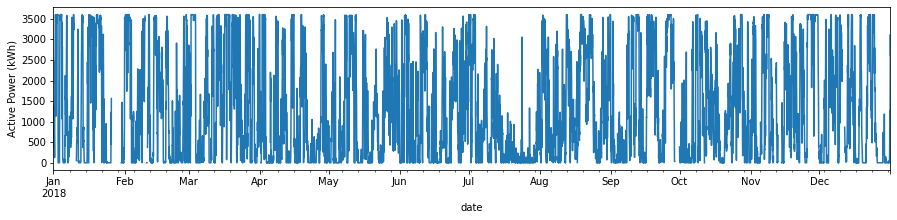

In [7]:
# Resample hourly average power and plot
df.resample('H').mean().active_power.plot(figsize=(15,3), ylabel='Active Power (kWh)')

### No es conveniente ver una gráfica horaria como esta. En cambio, podemos agrupar el marco de datos por horas (hora 0 a 24) y luego tomar el promedio de la potencia activa.

In [8]:
# Get hours from datetime
dates = df.index
hours = [date.hour for date in dates]
df['hour'] = hours
df


,active_power,wind_speed,theor_power,wind_dir,hour
date,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,0
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,0
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,0
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,0
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,0
...,...,...,...,...,...
2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,23
2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,23
2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,23


<AxesSubplot:title={'center':'Average of Active Power of each Hours'}, xlabel='hour'>

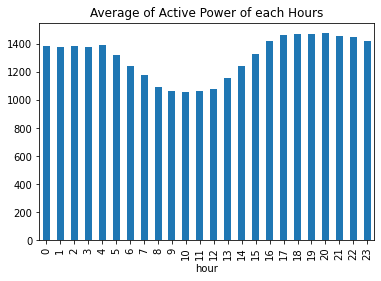

In [9]:
df.groupby('hour').mean().active_power.plot(kind='bar', title='Average of Active Power of each Hours')

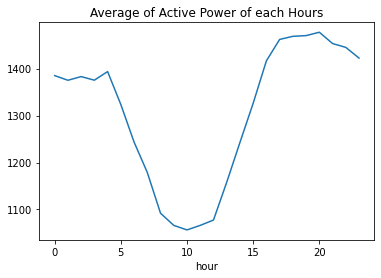

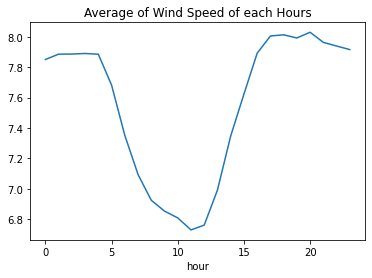

In [10]:
df.groupby('hour').mean().active_power.plot(title='Average of Active Power of each Hours')
plt.show()
df.groupby('hour').mean().wind_speed.plot(title='Average of Wind Speed of each Hours')
plt.show()


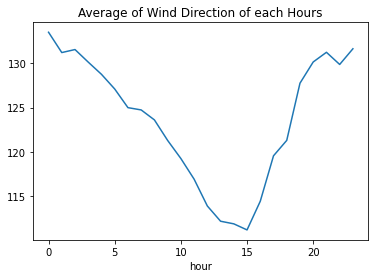

In [11]:
df.groupby('hour').mean().wind_dir.plot(title='Average of Wind Direction of each Hours')
plt.show()

### Monthly and weekly analysis

In [12]:
# Get hours from datetime
dates = df.index
months = [date.month for date in dates]
df['month'] = months

df

,active_power,wind_speed,theor_power,wind_dir,hour,month
date,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,0,1
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,0,1
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,0,1
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,0,1
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,0,1
...,...,...,...,...,...,...
2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,23,12
2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,23,12
2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,23,12


In [13]:
color = list(np.full(12, 'grey'))
color[2] = 'green'
color

['grey',
 'grey',
 'green',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey']

Text(0, 0.5, 'Active Power [kW]')

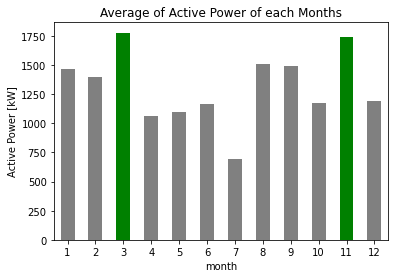

In [14]:
color = list(np.full(12, 'grey'))
color[2], color[10] = 'green', 'green'

df.groupby('month').mean().active_power.plot(kind='bar', title='Average of Active Power of each Months', color=color, rot=0)
plt.ylabel('Active Power [kW]')

<AxesSubplot:xlabel='date'>

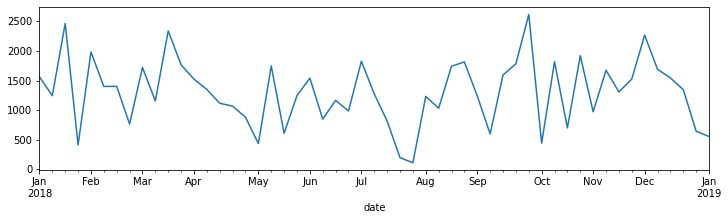

In [15]:
# Resample weekly average power and plot
df.resample('W').mean().active_power.plot(figsize=(12,3))

<AxesSubplot:xlabel='date'>

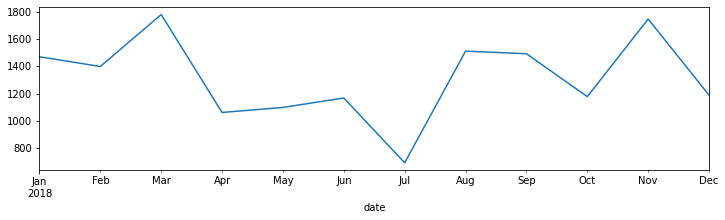

In [16]:
# Resample monthly average power and plot
df.resample('M').mean().active_power.plot(figsize=(12,3))

In [17]:
# Calculate power loss
df['loss'] = df['theor_power'] - df['active_power']

df

,active_power,wind_speed,theor_power,wind_dir,hour,month,loss
date,,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,0,1,36.281117
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,0,1,66.148316
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,0,1,84.523429
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,0,1,96.481664
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,0,1,111.052276
...,...,...,...,...,...,...,...
2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,23,12,433.209835
2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,23,12,-511.297256
2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,23,12,-412.822178


<AxesSubplot:xlabel='date'>

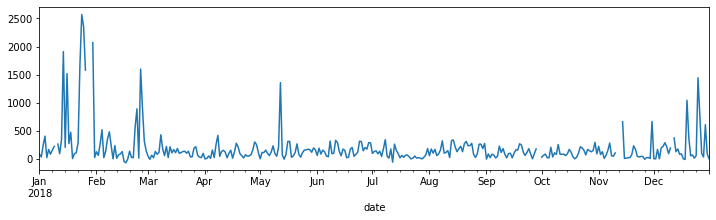

In [18]:
# Resample weekly average loss and plot
df.resample('D').mean().loss.plot(figsize=(12,3))

### 3. Wind power curve analysis

<AxesSubplot:xlabel='wind_speed'>

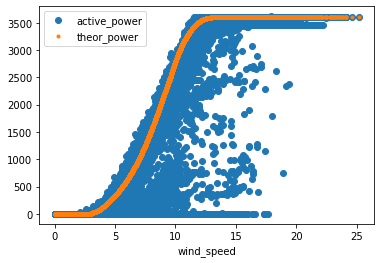

In [19]:
ax = df.plot(x='wind_speed', y='active_power', style='o')
df.plot(x='wind_speed', y='theor_power', style='.', ax=ax)

### Se trazan demasiados valores. Podemos agrupar los datos por velocidad del viento, es decir, velocidad del viento 0,25-0,75, 0,75-1,25, etc., y luego tomar un promedio de la potencia activa.

In [20]:
interval = np.arange(0.15,24,0.5)
df.groupby(pd.cut(df['wind_speed'], interval)).mean().head(10)

,active_power,wind_speed,theor_power,wind_dir,hour,month,loss
wind_speed,,,,,,,
"(0.15, 0.65]",0.000000,0.506610,0.000000,172.165239,11.816479,6.940075,0.000000
"(0.65, 1.15]",0.000000,0.922196,0.000000,174.185319,11.072581,7.021889,0.000000
"(1.15, 1.65]",0.004565,1.416297,0.000000,175.450217,10.802172,6.872770,-0.004565
"(1.65, 2.15]",0.044620,1.909948,0.000000,171.112225,10.857143,6.933488,-0.044620
"(2.15, 2.65]",0.307145,2.407513,0.000000,165.181465,11.154031,6.684261,-0.307145
"(2.65, 3.15]",3.206355,2.903285,5.954131,152.973536,10.850957,6.473108,2.747776
"(3.15, 3.65]",18.545798,3.392373,42.538528,143.333446,11.019695,6.527326,23.992730
"(3.65, 4.15]",71.399693,3.899335,109.394705,139.413723,11.291538,6.500516,37.995012
"(4.15, 4.65]",147.679549,4.396751,201.059081,131.865747,11.784285,6.695461,53.379532


<AxesSubplot:xlabel='wind_speed'>

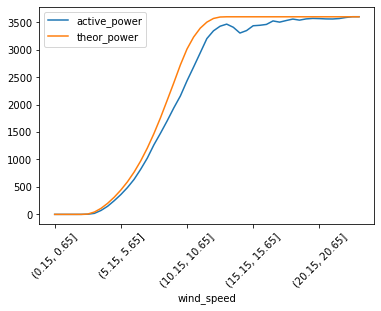

In [21]:
df.groupby(pd.cut(df['wind_speed'], interval)).mean().plot(y=['active_power', 'theor_power'], rot=45)

In [22]:
# A better look plot. This will display the mean value 0.5, 1, 1.5, etc., instead of the bins

def mean_power_curve(df):
    # Group by wind speed
    groups = df.groupby(pd.cut(df['wind_speed'], interval))
    mean_speed = []
    for key, item in groups:
        # Get keys from groupby method
        c = np.str(key)
        string = c[1:-1]
       
        string = string.split(', ')
        bounds = [float(i) for i in string]
        mean = np.mean(bounds)
        mean_speed.append(mean)
        
    # Take average of grouped df
    df_mean_speed = groups.mean()

    # Add mean speed to dataframe
    df_mean_speed['mean_speed'] = mean_speed

    # Plot
    df_mean_speed.plot(x='mean_speed', y=['theor_power', 'active_power'], style='.-')

Text(0.5, 1.0, 'Mean Power Curve')

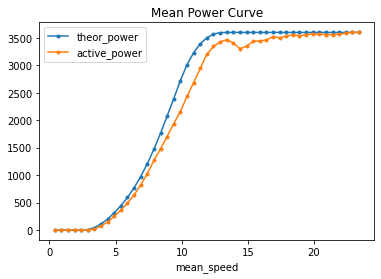

In [23]:
mean_power_curve(df)
plt.title('Mean Power Curve')
# plt.xlim(0,5)

### 4. Directivity analysis (+ power curve, again)

In [24]:
# create a function for a categorical column 11,25
def direction(x):
    if x > 348.75 or x<11.25: return 'N'
    if x < 33.75: return 'NNE'
    if x < 56.25: return 'NE'
    if x < 78.75: return 'ENE'
    if x < 101.25: return 'E'
    if x < 123.75: return 'ESE'
    if x < 146.25: return 'SE'
    if x < 168.75: return 'SSE'
    if x < 191.25: return 'S'
    if x < 213.75: return 'SSW'
    if x < 236.25: return 'SW'
    if x < 258.75: return 'WSW'
    if x < 281.25: return 'W'
    if x < 303.75: return 'WNW'
    if x < 326.25: return 'NW'
    else: return 'NNW'

In [25]:
df['direction'] = df['wind_dir'].apply(direction)

df

,active_power,wind_speed,theor_power,wind_dir,hour,month,loss,direction
date,,,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,0,1,36.281117,W
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,0,1,66.148316,W
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,0,1,84.523429,W
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,0,1,96.481664,W
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,0,1,111.052276,W
...,...,...,...,...,...,...,...,...
2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,23,12,433.209835,E
2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,23,12,-511.297256,E
2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,23,12,-412.822178,E


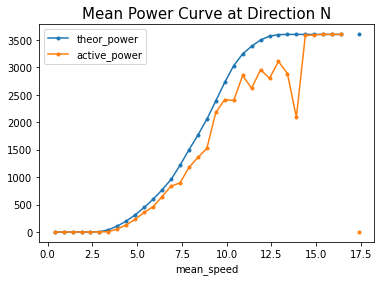

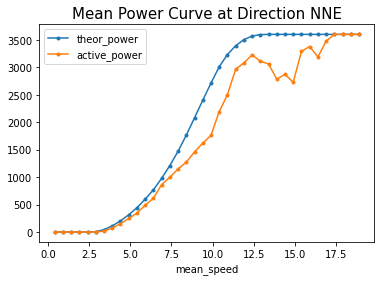

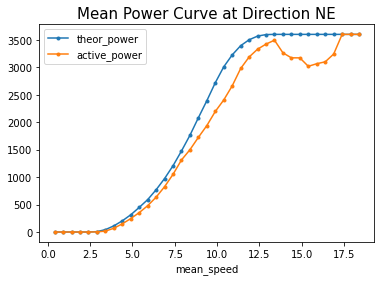

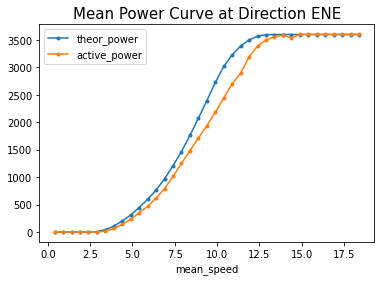

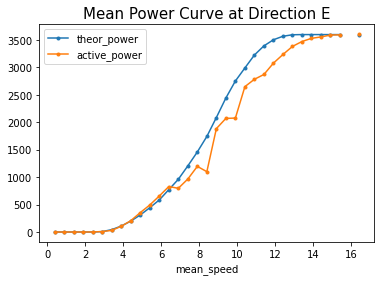

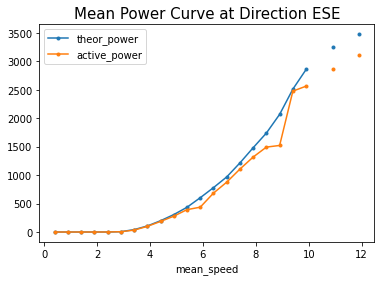

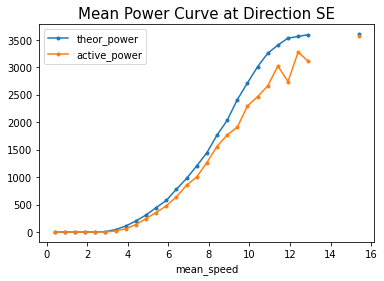

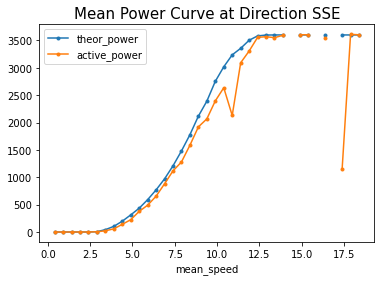

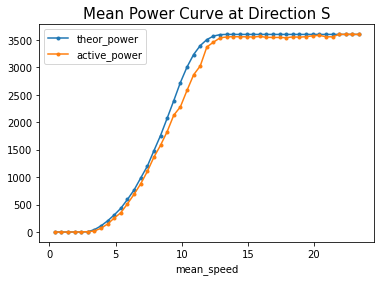

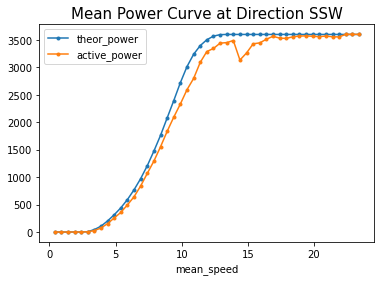

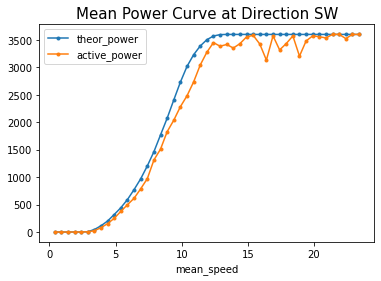

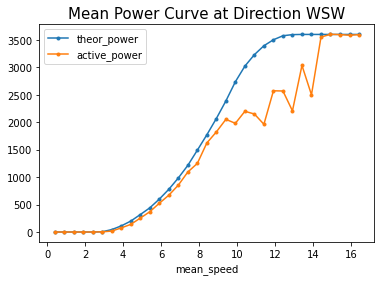

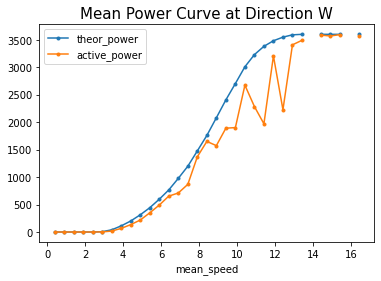

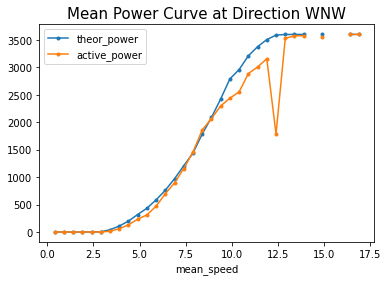

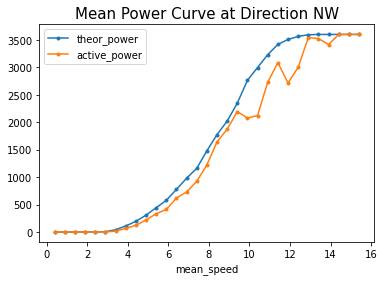

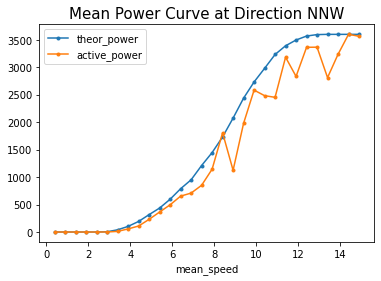

In [26]:

directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']

for d in directions:
    # Dataframe from one direction
    df_d = df[df.direction==d]
    # Plot mean power curve
    mean_power_curve(df_d)
    plt.title(f'Mean Power Curve at Direction {d}', size=15)
#     plt.xlim(0,5)

<AxesSubplot:title={'center':'Total Power Loss (kWh)'}, xlabel='direction'>

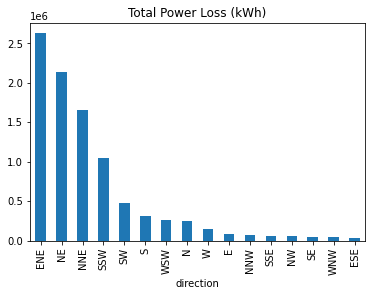

In [27]:
df.groupby('direction').loss.sum().sort_values(ascending=False).plot(kind='bar', title='Total Power Loss (kWh)')

<AxesSubplot:title={'center':'Wind Speed (m/s)'}, xlabel='direction'>

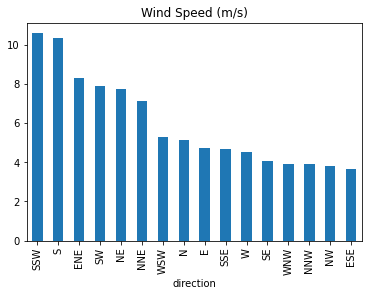

In [28]:
df.groupby('direction').wind_speed.mean().sort_values(ascending=False).plot(kind='bar', title='Wind Speed (m/s)')

In [29]:
df.isnull().sum()

active_power    0
wind_speed      0
theor_power     0
wind_dir        0
hour            0
month           0
loss            0
direction       0
dtype: int64

In [30]:
df.describe()

,active_power,wind_speed,theor_power,wind_dir,hour,month,loss
count,50530.000000,50530.000000,50530.000000,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559,11.517356,6.565110,184.491131
std,1312.459242,4.227166,1368.018238,93.443736,6.934626,3.395372,427.701555
min,-2.471405,0.000000,0.000000,0.000000,0.000000,1.000000,-598.741011
25%,50.677890,4.201395,161.328167,49.315437,5.000000,4.000000,0.000000
50%,825.838074,7.104594,1063.776283,73.712978,12.000000,7.000000,66.682623
75%,2482.507568,10.300020,2964.972462,201.696720,18.000000,10.000000,194.562692
max,3618.732910,25.206011,3600.000000,359.997589,23.000000,12.000000,3600.000000


In [31]:
df.count()

active_power    50530
wind_speed      50530
theor_power     50530
wind_dir        50530
hour            50530
month           50530
loss            50530
direction       50530
dtype: int64

In [32]:
df2 = df.copy()

# Remove negative active power
df_outlier_removed = df2[df2.active_power>0]



In [33]:
df_outlier_removed.count()

active_power    39692
wind_speed      39692
theor_power     39692
wind_dir        39692
hour            39692
month           39692
loss            39692
direction       39692
dtype: int64

In [34]:
# When wind speed is below 3.5, there is still power
df_outlier_removed[(df_outlier_removed.wind_speed<=3.5) & (df_outlier_removed.active_power!=0)]

,active_power,wind_speed,theor_power,wind_dir,hour,month,loss,direction
date,,,,,,,,
2018-01-01 12:30:00,41.947239,3.253968,29.286956,233.065903,12,1,-12.660283,SW
2018-03-01 15:30:00,7.347679,3.011371,16.374212,238.690598,15,3,9.026533,WSW
2018-03-01 15:50:00,12.344200,3.246252,28.731272,238.076508,15,3,16.387072,WSW
2018-05-01 07:30:00,13.934310,3.227394,27.413258,62.523109,7,5,13.478948,ENE
2018-05-01 08:10:00,22.780531,3.310203,33.624574,74.864113,8,5,10.844043,ENE
...,...,...,...,...,...,...,...,...
2018-12-18 01:40:00,6.939387,3.133558,21.700877,49.132389,1,12,14.761490,NE
2018-12-21 05:40:00,20.305180,2.648756,0.000000,175.433197,5,12,-20.305180,S
2018-12-21 05:50:00,4.730608,2.157747,0.000000,172.074402,5,12,-4.730608,S


### And we identify some events when there is ZERO power produced although wind speed is above 3 m/s and theoretical power is expected to be not ZERO. We see these happen most frequently in January and December.

<AxesSubplot:xlabel='date'>

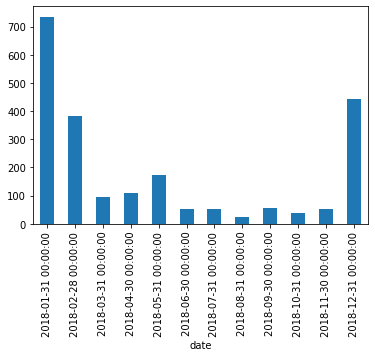

In [35]:
df_zero_power = df[(df.active_power==0) & (df.theor_power!=0) & (df.wind_speed>3.5)]
# Plot the frequency (counts) of ZERO power of every month
df_zero_power.resample('M').count().active_power.plot(kind='bar')

### Interestingly, we can identify some events when active power exceeds theoretical power. This is very beneficial, but suspicious because active power is often lower than theoretical power.

<AxesSubplot:xlabel='date'>

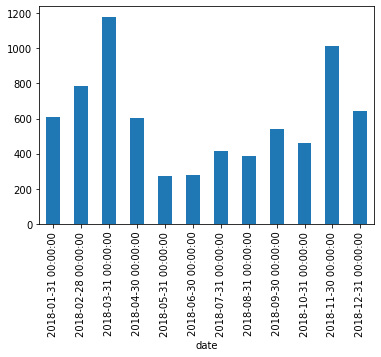

In [36]:
df[(df.active_power>df.theor_power)].resample('M').count().active_power.plot(kind='bar')

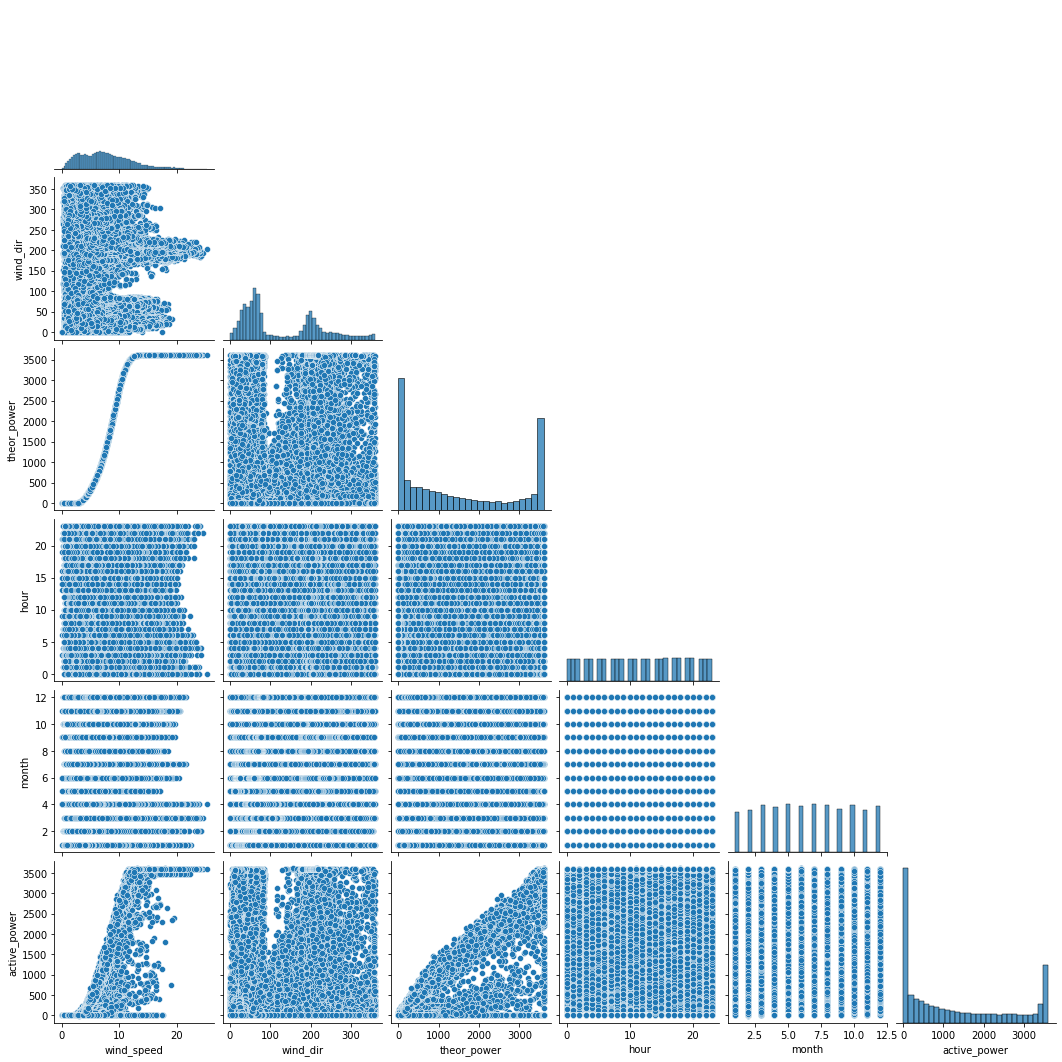

In [37]:
sns.pairplot(df, vars=['wind_speed', 'wind_dir', 'theor_power', 'hour', 'month', 'active_power'], corner=True)

In [38]:
df.dtypes


active_power    float64
wind_speed      float64
theor_power     float64
wind_dir        float64
hour              int64
month             int64
loss            float64
direction        object
dtype: object

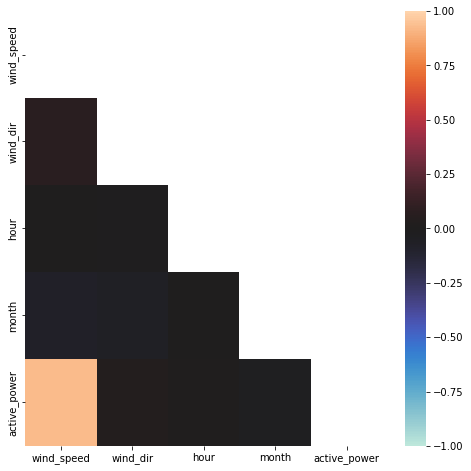

In [39]:
def corr_heatmap(df):    
    plt.figure(figsize=(8,8))

    mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
    sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, cmap='icefire')

corr_heatmap(df_outlier_removed[['wind_speed', 'wind_dir', 'hour', 'month', 'active_power']])

### Support Vector Machine

In [40]:
# Features and target: use only wind direction and wind speed
X = df_outlier_removed[['wind_dir', 'wind_speed']]
y = df_outlier_removed['active_power']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Make pipeline
pipe = make_pipeline(StandardScaler(), SVR())

# 5-fold CV
r2_cv = cross_val_score(pipe, X_train, y_train, cv=5)
print(r2_cv)
print(np.mean(r2_cv))

[0.94164981 0.93732246 0.93972004 0.94354066 0.94329232]
0.9411050586370242


In [41]:
# Features and target: now include hour and month as temporal features
X = df_outlier_removed[['wind_dir', 'wind_speed', 'hour', 'month']]
y = df_outlier_removed['active_power']

trees = [XGBRegressor(), Ada(), LGBMRegressor()]

for tree in trees:
    # Make pipeline
    pipe = make_pipeline(StandardScaler(), tree)
    
    # 10-fold CV
    r2_cv = cross_val_score(pipe, X_train, y_train, cv=8)
    print(f'{pipe.steps[1][1]}: {np.mean(r2_cv)}')

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...): 0.9571218278654718
AdaBoostRegressor(): 0.905980431356584
LGBMRegressor(): 0.9604177691474902
